In [1]:
__author__ = 'Brian Merino <brian.merino@noirlab.edu>'
__version__ = '04/29/2025' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['Aladin','des','skymapper','globular clusters']

# Displaying images and catalogs with Aladin Lite v3

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Start Aladin viewer](#Aladin)
* [Accessing the data](#Data)
* [Simple Image Access (SIA) Service Tool](#SIA)
* [Query the des_dr2 imaging data](#des_dr2)
* [Querying the Data Lab database](#Query)
* [Overlay table](#overlay_table)

<a class="anchor" id="goals"></a>
# Goals
Demonstrate the process of querying the Data Lab utilizing the query client service and the Simple Image Access (SIA) protocol to retrieve image cutouts. Show how to display the catalog and image data using the Aladin Lite viewer.


<a class="anchor" id="summary"></a>
# Summary
Aladin Lite is an interactive sky atlas that runs in your browser. Aladin can be used to explore the sky and has built-in functionality that makes it possible to overlay images onto the viewer and identify objects included in databases. This notebook will demonstrate how to create and overlay several MOCs onto Aladin, which would help identify overlapping datasets. 

The MOCs generated in this notebook will be used to display the survey footprints, making it possible to visualize any overlaps. 

Visualizing surveys like this could help identify whether a source of interest has already been observed by a survey in the Data Lab, which could be helpful in preparing a telescope proposal. 



<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., <a href="http://dx.doi.org/10.1117/12.2057445">"The NOAO Data Laboratory: a conceptual overview"</a>, SPIE, 9149, 2014

* <a href="https://datalab.noirlab.edu/disclaimers.php">Data Lab disclaimer</a>

<a class="anchor" id="imports"></a>
# Imports and setup

In [32]:
import numpy as np

import matplotlib.pyplot as plt

# Data Lab
from dl import authClient as ac, queryClient as qc #, storeClient as sc

# Standard lib
from getpass import getpass

#astropy
import astropy.units as u
from astropy.wcs import WCS
from astropy.table import Table
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.coordinates import SkyCoord

from pyvo.dal import sia

from ipyaladin import Aladin
from sidecar import Sidecar

import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

%matplotlib inline

<a class="anchor" id="Aladin"></a>
# Start Aladin Viewer

Let's start by opening an Aladin Lite viewer using SideCar. Running the following cell will open a new window to the right of where the notebook's cells are shown. 

Note: You do not need to use Sidecar to establish an Aladin Lite viewer session. If you were to just run the first line of the cell block, Aladin Lite would be opened below the code block. You could still interact with the viewer and utilize all of Aladin Lite's tools, but the session would remain below this code block, meaning you would need to scroll back up to this cell everytime you wanted to visit the viewer. 

In [19]:
aladin = Aladin()
with Sidecar(title="aladin_output"):
    display(aladin)

Now that Aladin is running, let's center it on our target, the globular cluster NGC 1851. 

In [4]:
#Center Aladin on NGC 1851
ra = 78.525 # in degrees
dec = -40.049 # in degrees
target_coord = SkyCoord(ra*u.deg,dec*u.deg)
aladin.target = target_coord

<a class="anchor" id="Data"></a>
# Accessing the data

In this notebook, we are going to access two different datasets. First, we will use the Simple Image Access (SIA) service tool to access imaging data from The **D**ark **E**negery **S**urvey [(**DES**)](https://datalab.noirlab.edu/des/index.php), then we will use the query client to access the [**SkyMapper**](https://datalab.noirlab.edu/data/skymapper) fourth data release to identify sources near our target. 

Note: If you want to know where to find the URL used here, check out this [Astro Data Lab user manual page](https://datalab.noirlab.edu/docs/manual/UsingAstroDataLab/DataAccessInterfaces/SimpleImageAccessSIA/SimpleImageAccessSIA.html?highlight=sia) for the list of image collection URLs and other helpful information on using the SIA tool. 

### Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). However, some capacities, such as saving the results of your queries to your virtual storage space, require a login (i.e., you will need a registered user account).

If you need to log in to Data Lab, un-comment the first line of code in the cell below and execute it:

In [34]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'bmerino95'

<a class="anchor" id="SIA"></a>
# SIA service tool

To access the SIA service tool, we need to establish the URL that points to the collection that holds the images we are interested in. For this example, we will access data from the des_dr2 image collection. 

In [28]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2"
svc_des_dr2 = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="des_dr2"></a>
# Query the des_dr2 imaging data

Since we are working with data for the globular cluster NGC 1851 (RA = 78.525 degrees and Dec = -40.049 degrees), we will search for corresponding images in the des_dr2 image collection around these coordinates. Since the field of view (fov) parameter expects values in degrees, we do not need to use a large value.  

In [29]:
fov = .2 # in degrees
imgTable_des_dr2 = svc_des_dr2.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
print(f"There are {len(imgTable_des_dr2)} matches. ")

There are 33 matches. 


Preview the table

In [8]:
imgTable_des_dr2

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=1&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=1&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=2&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=2&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=3&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=3&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y_nobkg.fits.fz&extn=1&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y_nobkg.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y_nobkg.fits.fz&extn=1&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y_nobkg.fits.fz&extn=2&POS=78.525,-40.049&SIZE=0.26126904201576734,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2

The returned table has a lot of information, but we are only interested in two columns. The first is called prodtype, which tells you what product type is stored in each row. The next column we want is called proctype. This column tells you how the image was processed. For our case, we want images that have been stacked, so we will create a filter that only returns rows where prodtype = 'image' and proctype = 'stack'.

In [25]:
sel_des_dr2 = (imgTable_des_dr2['prodtype'] == 'image') & (imgTable_des_dr2['proctype'] == 'Stack')

#Apply the filter to the table
row_des_dr2 = imgTable_des_dr2[sel_des_dr2]
print(len(row_des_dr2))

33


Now that we have a table of images, let's choose the first, fourth, and seventh images. To access the images we can use their access urls to download them directly into our notebook.

In [11]:
#Image 1
row_1 = imgTable_des_dr2[sel_des_dr2][0]
url_1 = row_1['access_url'] # get the download URL
filename_1 = download_file(url_1,cache=True,show_progress=False,timeout=120)
hdu_1 = fits.open(filename_1)[0]
image_1 = hdu_1.data
hdr_1 = hdu_1.header
wcs_1 = WCS(hdr_1)

In [12]:
#Image 2
row_2 = imgTable_des_dr2[sel_des_dr2][3]
url_2 = row_2['access_url'] # get the download URL
filename_2 = download_file(url_2,cache=True,show_progress=False,timeout=120)
hdu_2 = fits.open(filename_2)[0]
image_2 = hdu_2.data
hdr_2 = hdu_2.header
wcs_2 = WCS(hdr_2)

In [13]:
#Image 3
row_3 = imgTable_des_dr2[sel_des_dr2][6]
url_3 = row_3['access_url'] # get the download URL
filename_3 = download_file(url_3,cache=True,show_progress=False,timeout=120)
hdu_3 = fits.open(filename_3)[0]
image_3 = hdu_3.data
hdr_3 = hdu_3.header
wcs_3 = WCS(hdr_3)

With all three images opened lets plot them using matplotlib to get an idea of what they look like. 

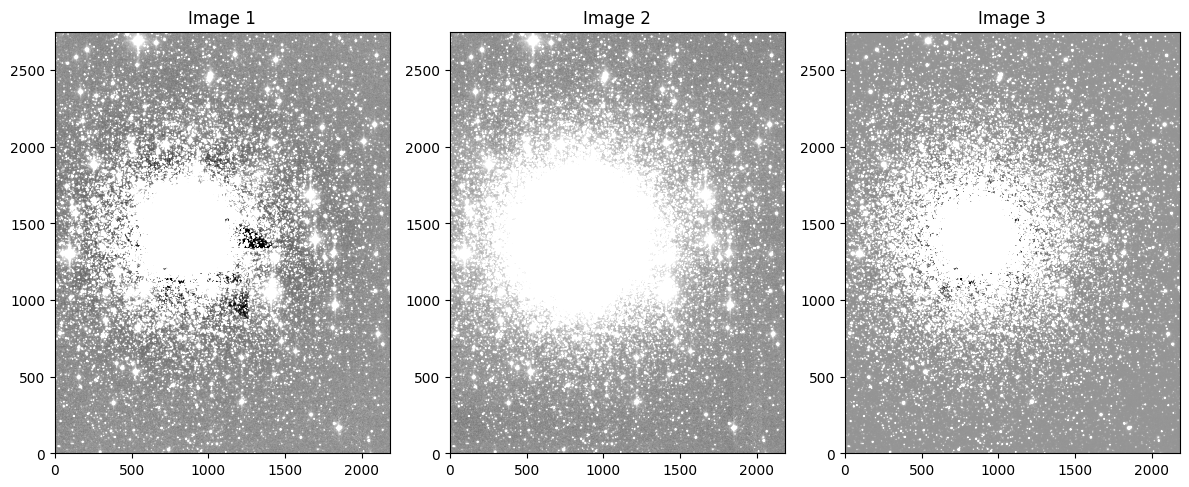

In [14]:
fig,ax = plt.subplots(1,3,figsize=(12,10))

ax[0].set_title('Image 1')
im1 = ax[0].imshow(image_1,origin='lower',cmap='Greys_r',vmin=-100,vmax=100)

ax[1].set_title('Image 2')
im2 = ax[1].imshow(image_2,origin='lower',cmap='Greys_r',vmin=-100,vmax=100)

ax[2].set_title('Image 3')
im3 = ax[2].imshow(image_3,origin='lower',cmap='Greys_r',vmin=-100,vmax=100)

plt.tight_layout()
plt.show()

<a class="anchor" id="overlay_image"></a>
# Overlay images on Aladin

After plotting all three images, we can verify that they are of the same source, but they are not identical. 

Now, we can use the add_fits() function to overlay the images onto Aladin. By default, Aladin sets the opacity of each image to 1.0, which means only the last image added will be visible. To remedy this, we will manually vary the opacities so that the second and third images are slightly transparent so that all three images can be seen.

In [15]:
#Add Image_1 to Aladin
aladin.add_fits(url_1,name='image_1',opacity=1.0,colormap='red')

#Add image_2 to Aladin
aladin.add_fits(url_2,name='image_2',opacity=0.5,colormap='green')

#Add image_2 to Aladin
aladin.add_fits(url_3,name='image_3',opacity=0.25,colormap='blue')

<a class="anchor" id="query"></a>
# Query Data Lab

Now that we know how to work with images, let's query the data lab to get data for individual stars in and around our target. We will use the SkyMapper data release 4 table for this notebook because our target falls within the survey's footprint. We only need the ra_img, dec_img, and object_id columns for this example. 

Since we already know the coordinates of our target, we can perform a cone search centered around the globular cluster. Note that we set the FOV to be 0.2 degrees when working with images because we wanted to find any images around our target, so we cast a wide net. For this query, we will need to narrow our FOV because SkyMapper DR4 contains data for **many** sources near our target. Using the same FOV as the image search would return 44,470 sources! Many of which have nothing to do with our target. If we narrow our FOV by just a factor of 3, the radius of the cone search becomes about twice as large as the diameter of the globular cluster. This query will still return a lot of sources, but this time, most of them are closer to our target. 

In [38]:
sql = '''SELECT ra_img, decl_img, object_id
            FROM skymapper_dr4.photometry
            WHERE Q3C_RADIAL_QUERY(ra_img,decl_img,{0},{1},{2})
'''.format(ra, dec, fov/3)
df = qc.query(sql=sql, fmt='pandas')
df

,ra_img,decl_img,object_id
0,78.488123,-40.108896,18814690
1,78.488021,-40.108831,18814690
2,78.488047,-40.108820,18814690
3,78.488099,-40.108846,18814690
4,78.488097,-40.108838,18814690
...,...,...,...
20639,78.572255,-39.993079,1026347587
20640,78.572274,-39.993079,1026347587
20641,78.572189,-39.993042,1026347587
20642,78.572241,-39.993061,1026347587


Let's see what the individual points look like when plotted over our first image. 

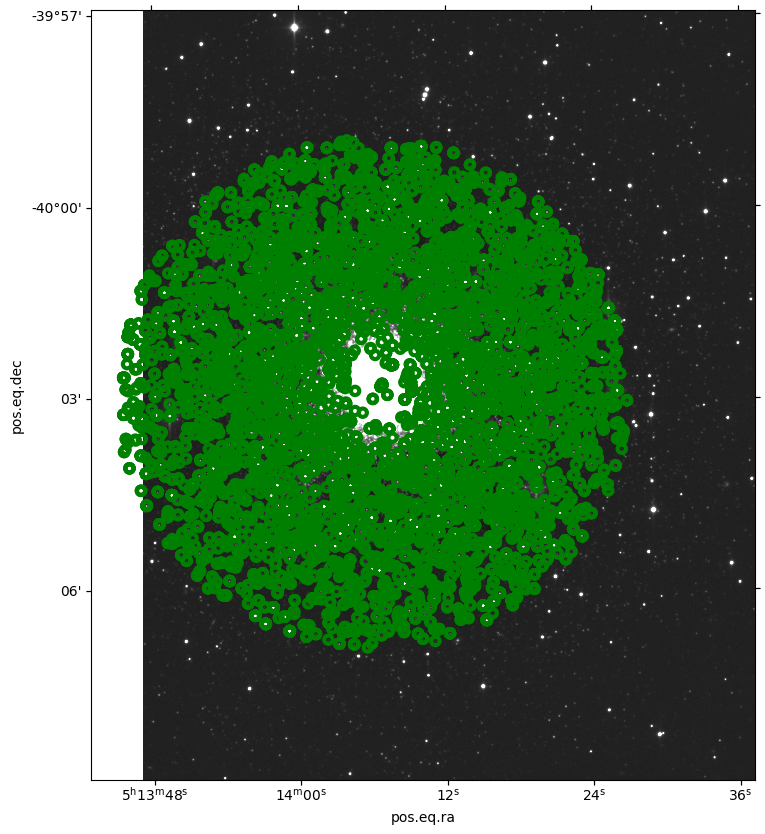

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs_1)
ax.imshow(image_1, cmap='gray', vmin=image_1.min(), vmax=image_1.min()+(image_1.max()-image_1.min())/100.)
ax.scatter(df['ra_img'], df['decl_img'], transform=ax.get_transform('icrs'),
           edgecolor='green', facecolor='none', linewidths=3)
plt.show()

<a class="anchor" id="overlay_table"></a>
# Overlay Table

Now, we are just about ready to overlay the data from this table on Aladin. But before we can overlay our table, we must first convert it from a 
pandas data frame to a table. 

Finally, we can use Aladin's built-in add_table() function to add the points to our Aladin viewer. 

In [39]:
t = Table.from_pandas(df)

aladin.add_table(
    t,
    shape='circle',
    source_size=15,
    color='lightblue')